In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import statsmodels.graphics.gofplots as sm
from scipy import stats
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from scipy.stats import permutation_test
from statsmodels.stats.power import TTestIndPower
from pathlib import Path
import numpy as np
%matplotlib inline

In [39]:
def ols_two_cols(df: pd.DataFrame, x: str, y: str):
    model = ols(f'{x} ~ {y}', data=df)
    res = model.fit()
    fig, axs = plt.subplots(2,2, squeeze=False)
    df['Prediction'] = res.predict(df)
    plt.tight_layout()
    
    ax = df.plot.scatter(x=f'{y}',y=f'{x}', ax=axs[0,0])
    df.plot(x=f'{x}',y='Prediction', ax=axs[0,0], color='red')
    # plt.subplot(2,2,2)
    residuals = res.predict(df)-df[f'{x}']
    axs[0,1].scatter(df[f'{y}'], (residuals))
    axs[0,1].set_xlabel(f'{y}')
    axs[0,1].set_ylabel('Residual values')
    
    axs[1,0].hist(residuals)
    axs[1,0].set_ylabel('frequency')
    axs[1,0].set_xlabel('residuual values')
    plt.subplot(2,2,4)
    sm.qqplot(residuals, stats.t, distargs=(4,), loc=3, scale=10, fit=True, ax=axs[1,1], line='s')
    plt.tight_layout()
    
    return model, res


In [76]:
def ols_two_cols_C(df: pd.DataFrame, x: str, y: str):
    model = ols(f'{x} ~ C({y})', data=df)
    res = model.fit()
    fig, axs = plt.subplots(2,2, squeeze=False)
    df['Prediction'] = res.predict(df)
    plt.tight_layout()
    
    ax = df.plot.scatter(x=f'{y}',y=f'{x}', ax=axs[0,0])
    df.plot(x=f'{x}',y='Prediction', ax=axs[0,0], color='red')
    # plt.subplot(2,2,2)
    residuals = res.predict(df)-df[f'{x}']
    axs[0,1].scatter(df[f'{y}'], (residuals))
    axs[0,1].set_xlabel(f'{y}')
    axs[0,1].set_ylabel('Residual values')
    
    axs[1,0].hist(residuals)
    axs[1,0].set_ylabel('frequency')
    axs[1,0].set_xlabel('residuual values')
    plt.subplot(2,2,4)
    sm.qqplot(residuals, stats.t, distargs=(4,), loc=3, scale=10, fit=True, ax=axs[1,1], line='s')
    plt.tight_layout()
    
    return model, res

In [41]:
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(8, 6))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

In [42]:
def read_store_csvs(path: Path):
    file_paths = [f for f in path.glob('store*.csv')]
    files = [pd.read_csv(f, low_memory=False) for f in file_paths]
    return file_paths, files

csvs_dir = Path("data")
file_paths, files = read_store_csvs(csvs_dir)
for file in files:
    file.set_index('Store', inplace=True)
stores_df = pd.concat(files[1:], axis=1)
store_data = files[0]
state_names = pd.read_csv(csvs_dir / 'state_names.csv')


In [43]:
def clear_df_from_nans(df: pd.DataFrame):
    df.CompetitionDistance.fillna(stores_df.CompetitionDistance.mean(),inplace = True)
    df.CompetitionOpenSinceMonth.fillna(method='bfill', axis=0,inplace = True)
    df.CompetitionOpenSinceMonth.dropna(axis=0, inplace=True)
    df.CompetitionOpenSinceYear.fillna(method='bfill', axis=0,inplace = True)
    df.CompetitionOpenSinceYear.dropna(axis=0, inplace=True)
    df.Promo2SinceWeek.fillna(method='bfill', axis=0,inplace = True)
    df.Promo2SinceWeek.dropna(axis=0, inplace=True)
    df.Promo2SinceYear.fillna(method='bfill', axis=0,inplace = True)
    df.Promo2SinceYear.dropna(axis=0, inplace=True)
    df.PromoInterval.fillna(method='bfill', axis=0, inplace = True)
    df.PromoInterval.dropna(axis=0, inplace=True)
    return df
    

In [44]:
def map_string_column(df: pd.DataFrame, column_name: str):
    unique_label_list = sorted(df[column_name].unique())
    #unique_label_list
    label_dict = { unique_label_list[i]: i for i in range(len(unique_label_list)) }
    df[column_name] = df[column_name].map(label_dict)
    return df, label_dict

In [45]:
store_data, holidays_dict = map_string_column(store_data, 'StateHoliday')
store_data.Date = pd.to_datetime(store_data.Date)
store_data

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
1111,2,2013-01-01,0,0,0,0,1,1
1112,2,2013-01-01,0,0,0,0,1,1
1113,2,2013-01-01,0,0,0,0,1,1


In [46]:
stores_df['Assortment'] = pd.Series(stores_df['Assortment'], dtype='string')
stores_df['StoreType'] = pd.Series(stores_df['StoreType'], dtype='string')
stores_df.reset_index(inplace=True)
stores_df, states_dict = map_string_column(stores_df, 'State')
stores_df, store_type_dict = map_string_column(stores_df, 'StoreType')
stores_df, assortment_dict = map_string_column(stores_df, 'Assortment')
stores_df.CompetitionDistance.fillna(stores_df.CompetitionDistance.mean(),inplace = True)
stores_df.CompetitionOpenSinceMonth.fillna(method='bfill', axis=0,inplace = True)
stores_df.CompetitionOpenSinceMonth.dropna(axis=0, inplace=True)
stores_df.CompetitionOpenSinceYear.fillna(method='bfill', axis=0,inplace = True)
stores_df.CompetitionOpenSinceYear.dropna(axis=0, inplace=True)
stores_df.Promo2SinceWeek.fillna(method='bfill', axis=0,inplace = True)
stores_df.Promo2SinceWeek.dropna(axis=0, inplace=True)
stores_df.Promo2SinceYear.fillna(method='bfill', axis=0,inplace = True)
stores_df.Promo2SinceYear.dropna(axis=0, inplace=True)
stores_df.PromoInterval.fillna(method='bfill', axis=0, inplace = True)
stores_df.PromoInterval.dropna(axis=0, inplace=True)
stores_df

,Store,State,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2,0,1270.0,9.0,2008.0,0,13.0,2010.0,"Jan,Apr,Jul,Oct"
1,2,11,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,0,2,2,620.0,9.0,2009.0,0,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,5,9,0,0,29910.0,4.0,2015.0,0,1.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,6,0,0,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,6,2,2,1880.0,4.0,2006.0,0,22.0,2012.0,"Mar,Jun,Sept,Dec"
1112,1113,8,0,2,9260.0,NaN,NaN,0,22.0,2012.0,"Mar,Jun,Sept,Dec"
1113,1114,5,0,2,870.0,NaN,NaN,0,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [47]:
states_dict

{'BE': 0,
 'BW': 1,
 'BY': 2,
 'HB,NI': 3,
 'HE': 4,
 'HH': 5,
 'NW': 6,
 'RP': 7,
 'SH': 8,
 'SN': 9,
 'ST': 10,
 'TH': 11}

In [48]:
state_names = pd.read_csv(csvs_dir / 'state_names.csv')
state_names['Numeric'] = state_names['State'].map(states_dict)
state_names.sort_values(by='Numeric', ascending=True, inplace=True)
state_names['Numeric'] = pd.Series(state_names['Numeric'], dtype='int')
state_names.dropna(inplace=True)
state_names

,StateName,State,Numeric
2,Berlin,BE,0.0
0,BadenWuerttemberg,BW,1.0
1,Bayern,BY,2.0
8,Niedersachsen,"HB,NI",3.0
6,Hessen,HE,4.0
5,Hamburg,HH,5.0
9,NordrheinWestfalen,NW,6.0
10,RheinlandPfalz,RP,7.0
14,SchleswigHolstein,SH,8.0
12,Sachsen,SN,9.0


In [49]:
weather = pd.read_csv(csvs_dir / 'weather.csv')
weather.Date = pd.to_datetime(weather.Date)
weather['State'] = pd.Series(weather['State'], dtype='string')
statename_to_state_id_dict = state_names[['StateName', 'Numeric']].set_index('StateName').to_dict()['Numeric']
weather['State'] = weather['State'].map(statename_to_state_id_dict)
weather.dropna(inplace=True)
weather['State'] = pd.Series(weather['State'], dtype='int')
weather

,State,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,6,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
24,6,2013-01-25,-2,-2,-3,-3,-4,-6,95,83,...,26.0,9.0,1.0,23,8,40.0,0.00,7.0,Fog-Rain-Snow,80
25,6,2013-01-26,0,-2,-4,-1,-4,-6,100,81,...,26.0,11.0,3.0,34,24,48.0,0.00,7.0,Rain-Snow,158
26,6,2013-01-27,4,2,-1,3,1,-2,95,86,...,26.0,12.0,5.0,35,21,53.0,3.05,7.0,Rain-Snow,174
28,6,2013-01-29,12,8,3,10,8,3,96,88,...,31.0,12.0,6.0,45,31,61.0,6.10,7.0,Rain,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,11,2015-09-01,27,21,14,17,13,11,88,64,...,31.0,14.0,10.0,43,13,52.0,0.00,6.0,Rain,266
14838,11,2015-09-06,15,11,7,9,7,6,88,75,...,31.0,11.0,10.0,42,27,60.0,0.00,4.0,Rain,269
14842,11,2015-09-10,16,12,8,9,8,6,94,81,...,31.0,13.0,6.0,26,8,45.0,2.03,6.0,Rain-Thunderstorm,36
14846,11,2015-09-14,19,16,12,15,12,10,98,78,...,26.0,11.0,5.0,42,13,61.0,8.89,6.0,Rain-Thunderstorm,202


# Analiza pod kątem zamknięcia sklepu

In [50]:
closed_count = store_data[store_data['Open'] == 0].count()[0]
print('Ilość zamkniętych sklepów (łącznie): ', closed_count)
national_holiday = store_data[store_data['StateHoliday'] == holidays_dict['a']].count()[0]
print('Ilość zamkniętych w święta państwowe i procentowy udział (łącznie): ', national_holiday, " | ", national_holiday/float(closed_count))
easter_holiday = store_data[store_data['StateHoliday'] == holidays_dict['b']].count()[0]
print('Ilość zamkniętych w święta wielkanocne i procentowy udział (łącznie): ', easter_holiday, " | ", easter_holiday/float(closed_count))
xmas_holiday = store_data[store_data['StateHoliday'] == holidays_dict['c']].count()[0]
print('Ilość zamkniętych w święta bożego narodzenia i procentowy udział (łącznie): ', xmas_holiday, " | ", xmas_holiday/float(closed_count))

Ilość zamkniętych sklepów (łącznie):  172817
Ilość zamkniętych w święta państwowe i procentowy udział (łącznie):  20260  |  0.11723383694891128
Ilość zamkniętych w święta wielkanocne i procentowy udział (łącznie):  6690  |  0.038711469357759945
Ilość zamkniętych w święta bożego narodzenia i procentowy udział (łącznie):  4100  |  0.02372451784257336


Na potrzeby późniejszej analizy powyższe dni nie zostaną uznane w danych ponieważ nie mają one wpływu na sprzedawalność, natomiast w chwili gdy jeden z wielu regionów ma święto kiedy reszta ich nie ma spowoduje to wysokie rozbieżności danych, które chciałbym wyeliminować.


In [51]:
store_data = pd.DataFrame(store_data[store_data['Open'] == 1])

In [52]:
store_data.sort_values('Date', ascending=True)
no_sales_stores = store_data[store_data['Sales'] == 0]
store_data = store_data[store_data['Sales'] > 0]
no_sales_stores

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
971,5,2015-05-15,0,0,1,0,0,1
674,4,2015-03-26,0,0,1,0,0,0
699,4,2015-02-05,0,0,1,1,0,0
708,3,2014-10-01,0,0,1,1,0,0
357,1,2014-09-22,0,0,1,0,0,0
227,4,2014-09-11,0,0,1,0,0,0
835,4,2014-09-11,0,0,1,0,0,0
835,3,2014-09-10,0,0,1,0,0,0
548,5,2014-09-05,0,0,1,1,0,1


W danych braku sprzedaży nie występują przypadki w których dane wyglądają niepokojąco. Wiele sklepów nie występuje wiele razy w różnych okresach czasu co może sugerować przykładowo, remonty techniczne, wymiany kas itp. w związku z tym dane zostaną odrzucone żeby nie sugerować się przypadkowymi awariami i innymi czynnikami zewnętrznymi źle wpływającymi na funkcjonowanie samego sklepu tak samo jak możliwe outliery spowodowane potencjalnym brakiem danych.

<AxesSubplot:>

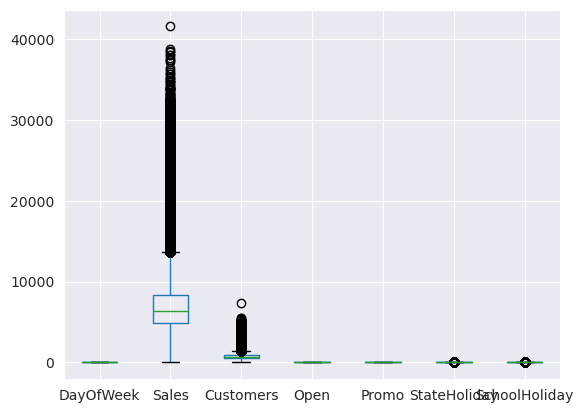

In [53]:
store_data.boxplot()

<AxesSubplot:>

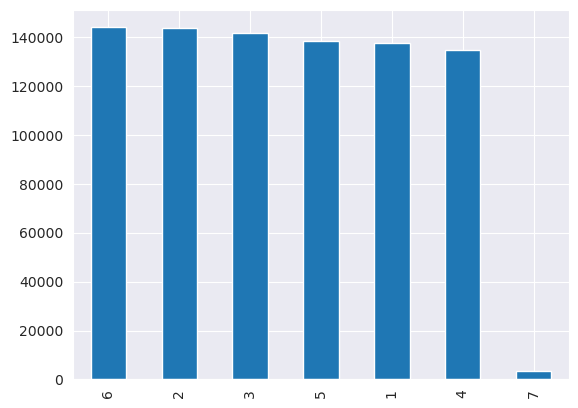

In [54]:
store_data['DayOfWeek'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

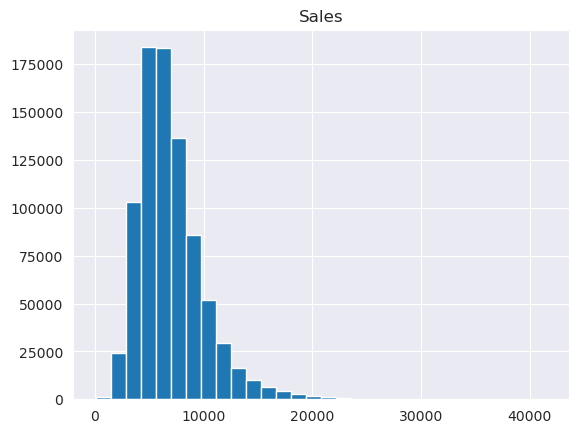

In [55]:
store_data.hist('Sales', bins=30)

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

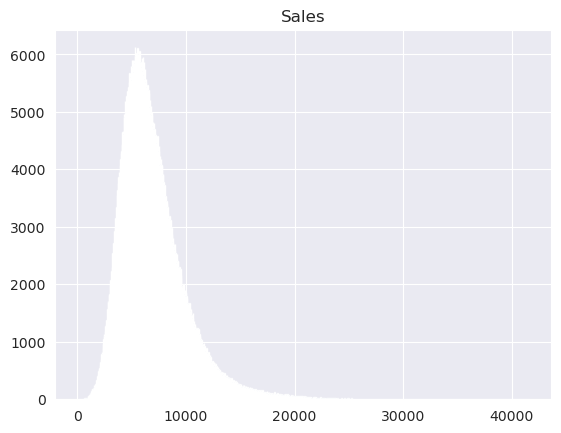

In [56]:
store_data.hist('Sales', bins=1000)

Na podstawie histogramów (pierwszy z małą ilością binów i drugi z dużą żeby zobaczyć dokładną dystrybucje danych) można stwierdzić że rozkład sprzedaży jest prawostronnie skośny oznacza to że wiele danych które mogą zostać potraktowane jako outliery (dane znajdujące się dalej prawej strony rozkładu, sugerując się medianą), mimo tego że nie oznacza to że dane te w istocie są outlierami na co trzeba uważać w kolejnych krokach. Znając zatem rozkład samego prognozowanego rodzaju danych możemy przejść do dalszej analizy tym razem na tle zależności pomiędzy danymi w zbiorze.


In [57]:
merged_df = store_data.copy()
merged_df = merged_df.merge(stores_df.reset_index(), on='Store', how='left')
merged_df.drop(['index'], axis=1, inplace=True)
merged_df = clear_df_from_nans(merged_df)
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,State,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,4,2,0,1270.0,9.0,2008.0,0,13.0,2010.0,"Jan,Apr,Jul,Oct"
1,2,5,2015-07-31,6064,625,1,1,0,1,11,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,6,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,2,2,620.0,9.0,2009.0,0,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,5,5,2015-07-31,4822,559,1,1,0,1,9,0,0,29910.0,4.0,2015.0,0,1.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,682,2,2013-01-01,3375,566,1,0,1,1,0,1,0,150.0,9.0,2006.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"
844334,733,2,2013-01-01,10765,2377,1,0,1,1,6,1,1,860.0,10.0,1999.0,0,36.0,2013.0,"Mar,Jun,Sept,Dec"
844335,769,2,2013-01-01,5035,1248,1,0,1,1,6,1,1,840.0,4.0,2015.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
844336,948,2,2013-01-01,4491,1039,1,0,1,1,1,1,1,1430.0,3.0,2006.0,0,40.0,2011.0,"Jan,Apr,Jul,Oct"


/tmp/ipykernel_20608/281042980.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index


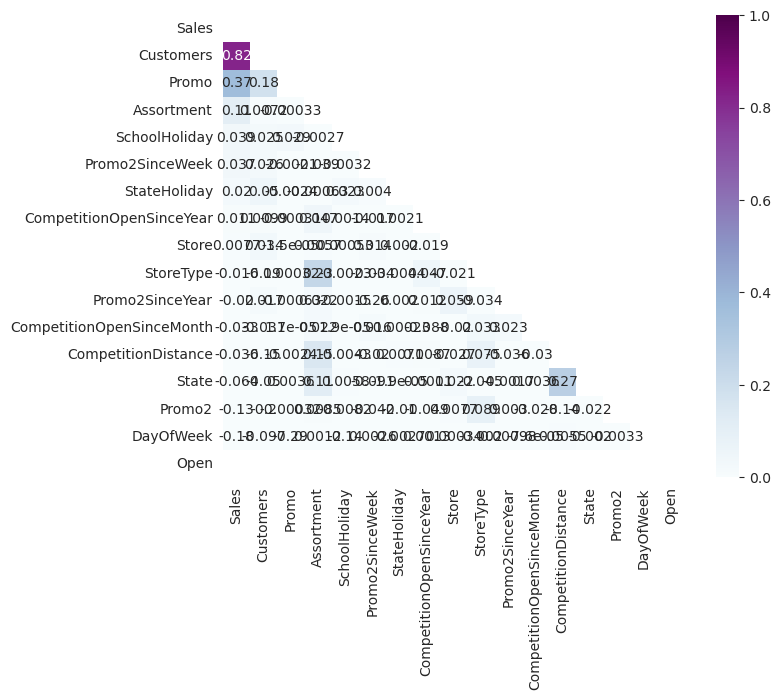

In [58]:
correlation_map(merged_df, 'Sales', len(merged_df.columns))

Ogólny wykres korelacji pozwala wysnuć pewne wnioski oraz przemyśleć możliwość tego które dane mogą od razu okazać się pomocne a które należy zweryfikować. Ku zaskoczeniu nikogo liczba klientów oraz trwająca promocja jest oczywiście najbardziej znaczącym elementem wpływającym na sprzedaż.

<AxesSubplot:>

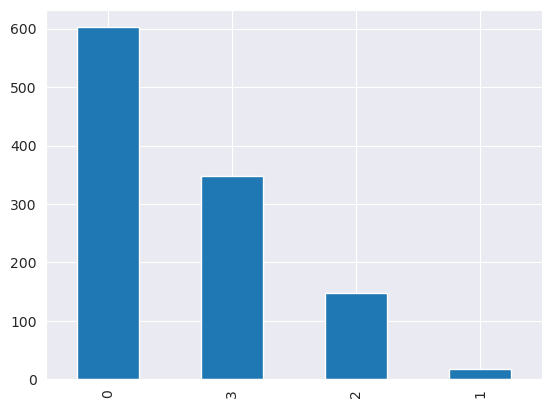

In [59]:
stores_df['StoreType'].value_counts().plot(kind='bar') # Sprawdzenie proporcji w jakiej rozkładają się dane typy

In [60]:
store_type_dict

{'a': 0, 'b': 1, 'c': 2, 'd': 3}

In [61]:
merged_df[['StoreType', 'Sales']].groupby('StoreType').agg('sum') # można zaobserować że istnieje pewna zależność jednak ciężko zdefiniować z czego ona wynika, natomiast same różnice są znaczące.

,Sales
StoreType,
0,3165334859
1,159231395
2,783221426
3,1765392943


<AxesSubplot:>

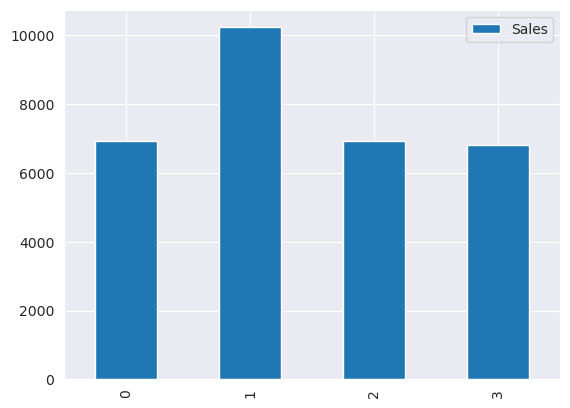

In [62]:
(merged_df[['StoreType', 'Sales']].groupby('StoreType').agg('sum') / pd.DataFrame(merged_df['StoreType'].value_counts()).rename(columns={'StoreType': 'Sales'})).plot(kind='bar')

/tmp/ipykernel_20608/281042980.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index


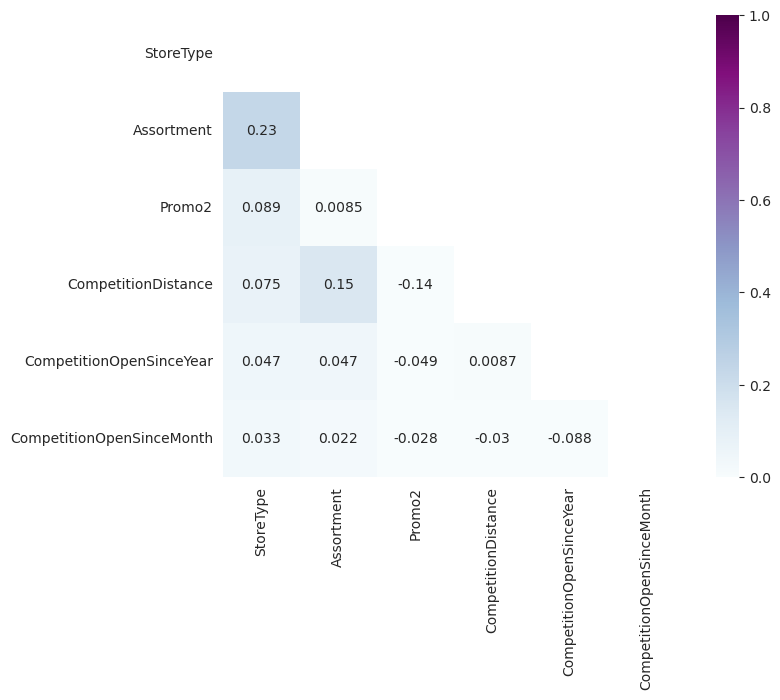

In [63]:
correlation_map(merged_df, 'StoreType', 6)

In [64]:
merged_df[['Assortment', 'Sales']].groupby('Assortment').agg('sum') 
# wyposażenie również posiada znaczące rozbieżności

,Sales
Assortment,
0,2945750070
1,70946312
2,2856484241


<AxesSubplot:>

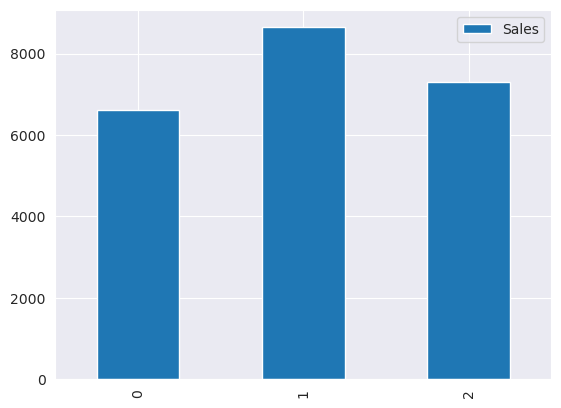

In [65]:
(merged_df[['Assortment', 'Sales']].groupby('Assortment').agg('sum')  / pd.DataFrame(merged_df['Assortment'].value_counts()).rename(columns={'Assortment': 'Sales'})).plot(kind="bar")

/tmp/ipykernel_20608/281042980.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index


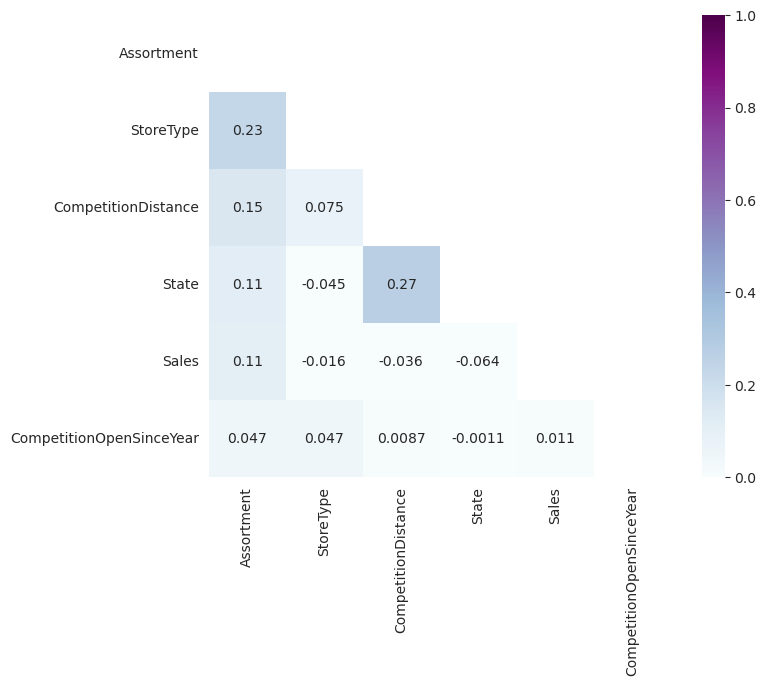

In [66]:
correlation_map(merged_df, 'Assortment', 6)

<AxesSubplot:>

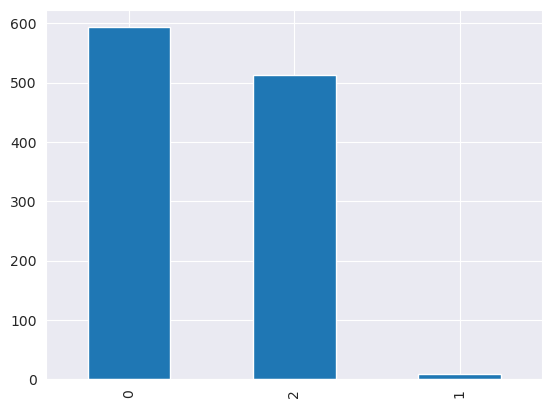

In [67]:
stores_df['Assortment'].value_counts().plot(kind='bar') # Sprawdzenie ilości sklepów z danej kategorii

Jak można zaobserwować obie zmienne są wzajemnie od siebie zależne jednak nie mają one znaczącego wpływu na sprzedaż, ponieważ jak można zaobserwować sprzedaż jest mocno powiązana z ilością tych sklepów. Jeżeli chodzi o obserwacje wynikające z ilości sprzedaży to można zaobserwować że po znormalizowaniu liczby sprzedaży przez wytępujące typy danych sklepów nie występuje znacząca różnica pomiędzy sprzedażą. Zarówno dla jednej jak i dla drugiej cechy mamy jeden typ który wyróżnia się spoza reszty natomiast pozostałe są wyrównane.

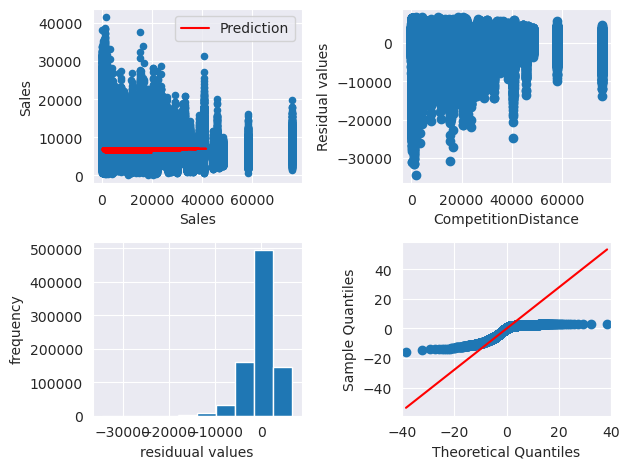

In [68]:
model, res = ols_two_cols(merged_df[['Sales', 'CompetitionDistance']].copy(), 'Sales', 'CompetitionDistance')

In [69]:
res.summary() # Wysoka szansa na to że wiele elementów modelu wpływa na sprzedaż, czyli najprawdopodobniej sam dystans nie ma aż tak znaczącego wpływu

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1120.
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          1.92e-245
Time:                        21:53:55   Log-Likelihood:            -7.9863e+06
No. Observations:              844338   AIC:                         1.597e+07
Df Residuals:                  844336   BIC:                         1.597e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            7035.0224      4.120   1707.513      0.000    7026.947    7043.097
CompetitionDistance    -0.0145      0.000    -33.470      0.000      -0.015      -0.014
==============================================================================
Omnibus:                   277905.750   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1163639.079
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       7.798   Cond. No.                     1.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

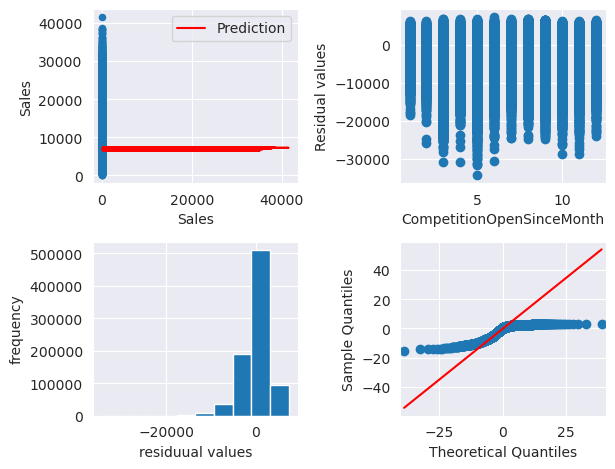

In [77]:
model, res = ols_two_cols_C(merged_df[['Sales', 'CompetitionOpenSinceMonth']].copy(), 'Sales', 'CompetitionOpenSinceMonth')

In [78]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     538.9
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:58:41   Log-Likelihood:            -7.9839e+06
No. Observations:              844338   AIC:                         1.597e+07
Df Residuals:                  844326   BIC:                         1.597e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             7263.1524     27.506    264.062      0.000    7209.242    7317.062
C(CompetitionOpenSinceMonth)[T.2.0]   -673.6885     30.765    -21.898      0.000    -733.987    -613.390
C(CompetitionOpenSinceMonth)[T.3.0]    -59.4981     29.451     -2.020      0.043    -117.221      -1.775
C(CompetitionOpenSinceMonth)[T.4.0]   -313.9004     29.285    -10.719      0.000    -371.298    -256.503
C(CompetitionOpenSinceMonth)[T.5.0]     -7.5972     30.548     -0.249      0.804     -67.469      52.275
C(CompetitionOpenSinceMonth)[T.6.0]    125.4570     30.486      4.115      0.000      65.706     185.208
C(CompetitionOpenSinceMonth)[T.7.0]   -411.1741     29.669    -13.859      0.000    -469.324    -353.024
C(CompetitionOpenSinceMonth)[T.8.0]    139.5614     31.306      4.458      0.000      78.203     200.920
C(CompetitionOpenSinceMonth)[T.9.0]   -335.1059     28.664    -11.691      0.000    -391.287    -278.925
C(CompetitionOpenSinceMonth)[T.10.0]  -400.5470     29.915    -13.390      0.000    -459.179    -341.915
C(CompetitionOpenSinceMonth)[T.11.0]  -744.7984     29.368    -25.361      0.000    -802.359    -687.238
C(CompetitionOpenSinceMonth)[T.12.0]  -421.7103     30.091    -14.014      0.000    -480.688    -362.732
==============================================================================
Omnibus:                   276223.386   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1153260.206
Skew:                           1.576   Prob(JB):                         0.00
Kurtosis:                       7.780   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     538.9
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:58:41   Log-Likelihood:            -7.9839e+06
No. Observations:              844338   AIC:                         1.597e+07
Df Residuals:                  844326   BIC:                         1.597e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             7263.1524     27.506    264.062      0.000    7209.242    7317.062
C(CompetitionOpenSinceMonth)[T.2.0]   -673.6885     30.765    -21.898      0.000    -733.987    -613.390
C(CompetitionOpenSinceMonth)[T.3.0]    -59.4981     29.451     -2.020      0.043    -117.221      -1.775
C(CompetitionOpenSinceMonth)[T.4.0]   -313.9004     29.285    -10.719      0.000    -371.298    -256.503
C(CompetitionOpenSinceMonth)[T.5.0]     -7.5972     30.548     -0.249      0.804     -67.469      52.275
C(CompetitionOpenSinceMonth)[T.6.0]    125.4570     30.486      4.115      0.000      65.706     185.208
C(CompetitionOpenSinceMonth)[T.7.0]   -411.1741     29.669    -13.859      0.000    -469.324    -353.024
C(CompetitionOpenSinceMonth)[T.8.0]    139.5614     31.306      4.458      0.000      78.203     200.920
C(CompetitionOpenSinceMonth)[T.9.0]   -335.1059     28.664    -11.691      0.000    -391.287    -278.925
C(CompetitionOpenSinceMonth)[T.10.0]  -400.5470     29.915    -13.390      0.000    -459.179    -341.915
C(CompetitionOpenSinceMonth)[T.11.0]  -744.7984     29.368    -25.361      0.000    -802.359    -687.238
C(CompetitionOpenSinceMonth)[T.12.0]  -421.7103     30.091    -14.014      0.000    -480.688    -362.732
==============================================================================
Omnibus:                   276223.386   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1153260.206
Skew:                           1.576   Prob(JB):                         0.00
Kurtosis:                       7.780   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

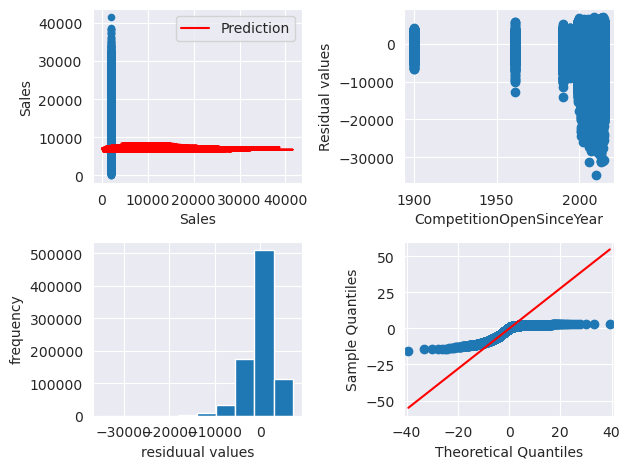

In [79]:
model, res = ols_two_cols_C(merged_df[['Sales', 'CompetitionOpenSinceYear']].copy(), 'Sales', 'CompetitionOpenSinceYear')

In [ ]:
res.summary()